# Simple regression with bayesian neural networks

In this notebook you will find a comparison between two bayesian methods to assess uncertainty when dealing with neural networks: **Monte-Carlo Dropout** (["Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)) and **Bayesian by Backpropagation** (["Weight Uncertainty in Neural Networks"](https://arxiv.org/abs/1505.05424)). We study a very simple toy regression model in 1D.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import torch
from torch.utils import data

## 0. Data preparation

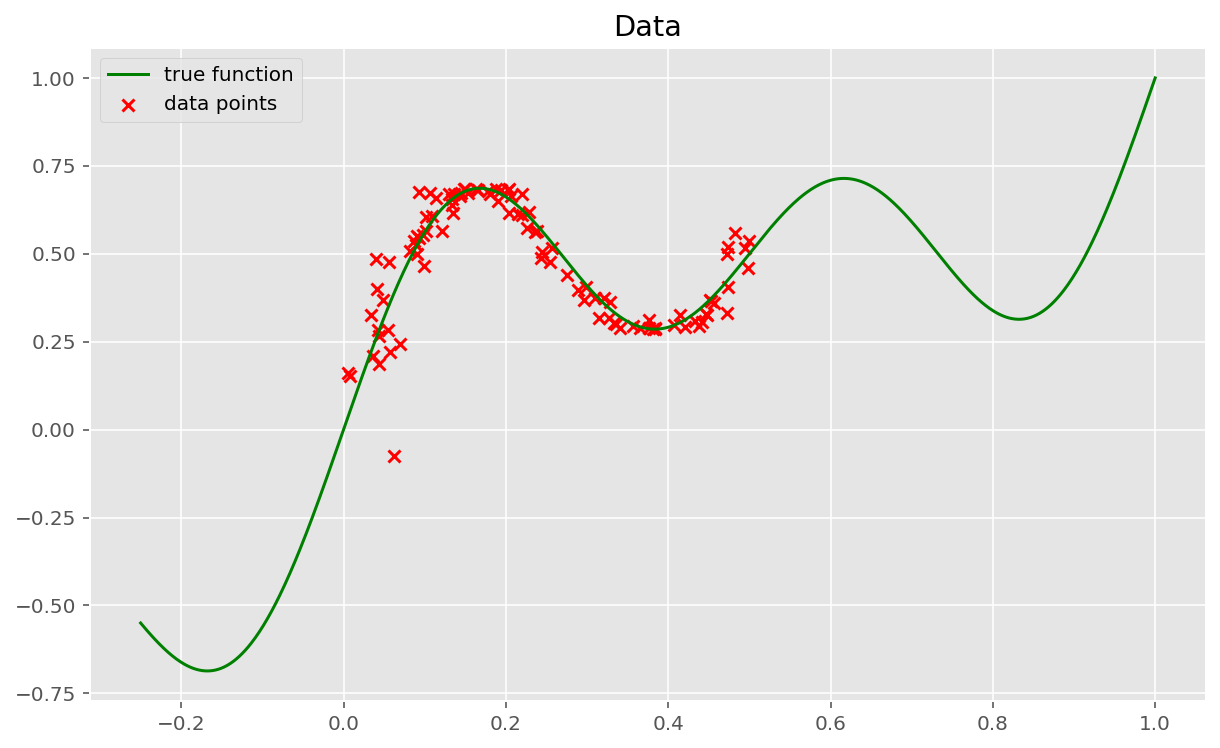

In [2]:
N = 100  #number of training data points
sigma = 0.02
dataset = {}

def function(x, epsilon):
    return x + 0.3 * np.sin(2 * np.pi * (x + epsilon)) + 0.3 * np.sin(4 * np.pi * (x + epsilon)) + epsilon

dataset['X_train'] = np.random.uniform(0, 0.5, N)
dataset['y_train'] = function(dataset['X_train'], np.random.normal(0, sigma, N))

dataset['X_test'] = np.linspace(-0.25, 1, 1000)
F = function(dataset['X_test'], 0)

plt.figure(figsize=(10, 6))
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.scatter(dataset['X_train'], dataset['y_train'], marker='x', color='red', label='data points')
plt.legend()
plt.title("Data")
plt.show()

In [3]:
X_train_tensor = torch.from_numpy(dataset['X_train'].copy()).float().unsqueeze(dim=1)
y_train_tensor = torch.from_numpy(dataset['y_train'].copy()).float()
X_test_tensor = torch.from_numpy(dataset['X_test'].copy()).float().unsqueeze(dim=1)

## 1. Deterministic regression

In [4]:
import models.deterministic_regression as dreg

##### Definition of the model

In [13]:
net = dreg.DeterministicNet(hidden_size=100, dim_input=1, dim_output=1)
reg_model = dreg.DeterministicReg(X_train_tensor, y_train_tensor, X_test_tensor, net)

##### Training step

In [14]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion, batch=False)

##### Test step

In [15]:
y_pred = reg_model.predict()

##### Plot results

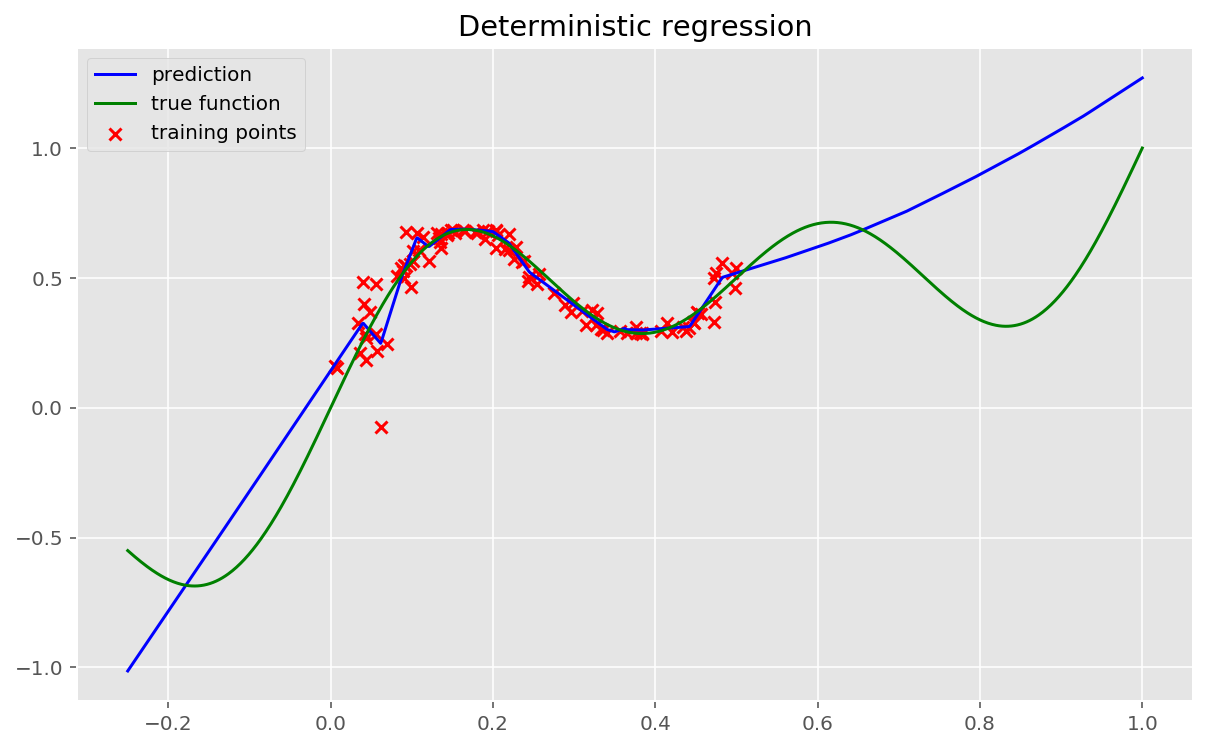

In [16]:
plt.figure(figsize=(10, 6))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title('Deterministic regression')
plt.show()

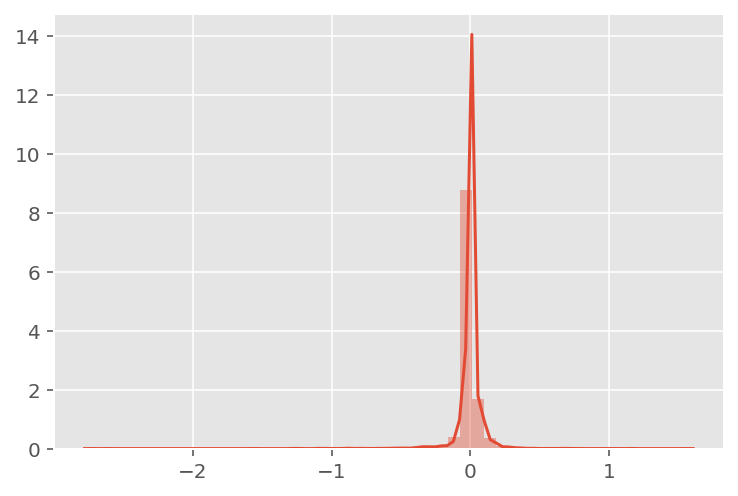

In [17]:
sns.distplot(net.weights_dist())

## 2. Bayesian regression with Monte-Carlo dropout

In [18]:
import models.dropout_regression as doreg

##### Definition of the model

In [23]:
net = doreg.DropoutNet(hidden_size=100, dim_input=1, dim_output=1, p=0.25)
reg_model = doreg.DropoutReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=X_train_tensor.shape[0])

##### Training step

In [24]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
reg_model.train(5000, optimizer, criterion)

##### Test step

In [25]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

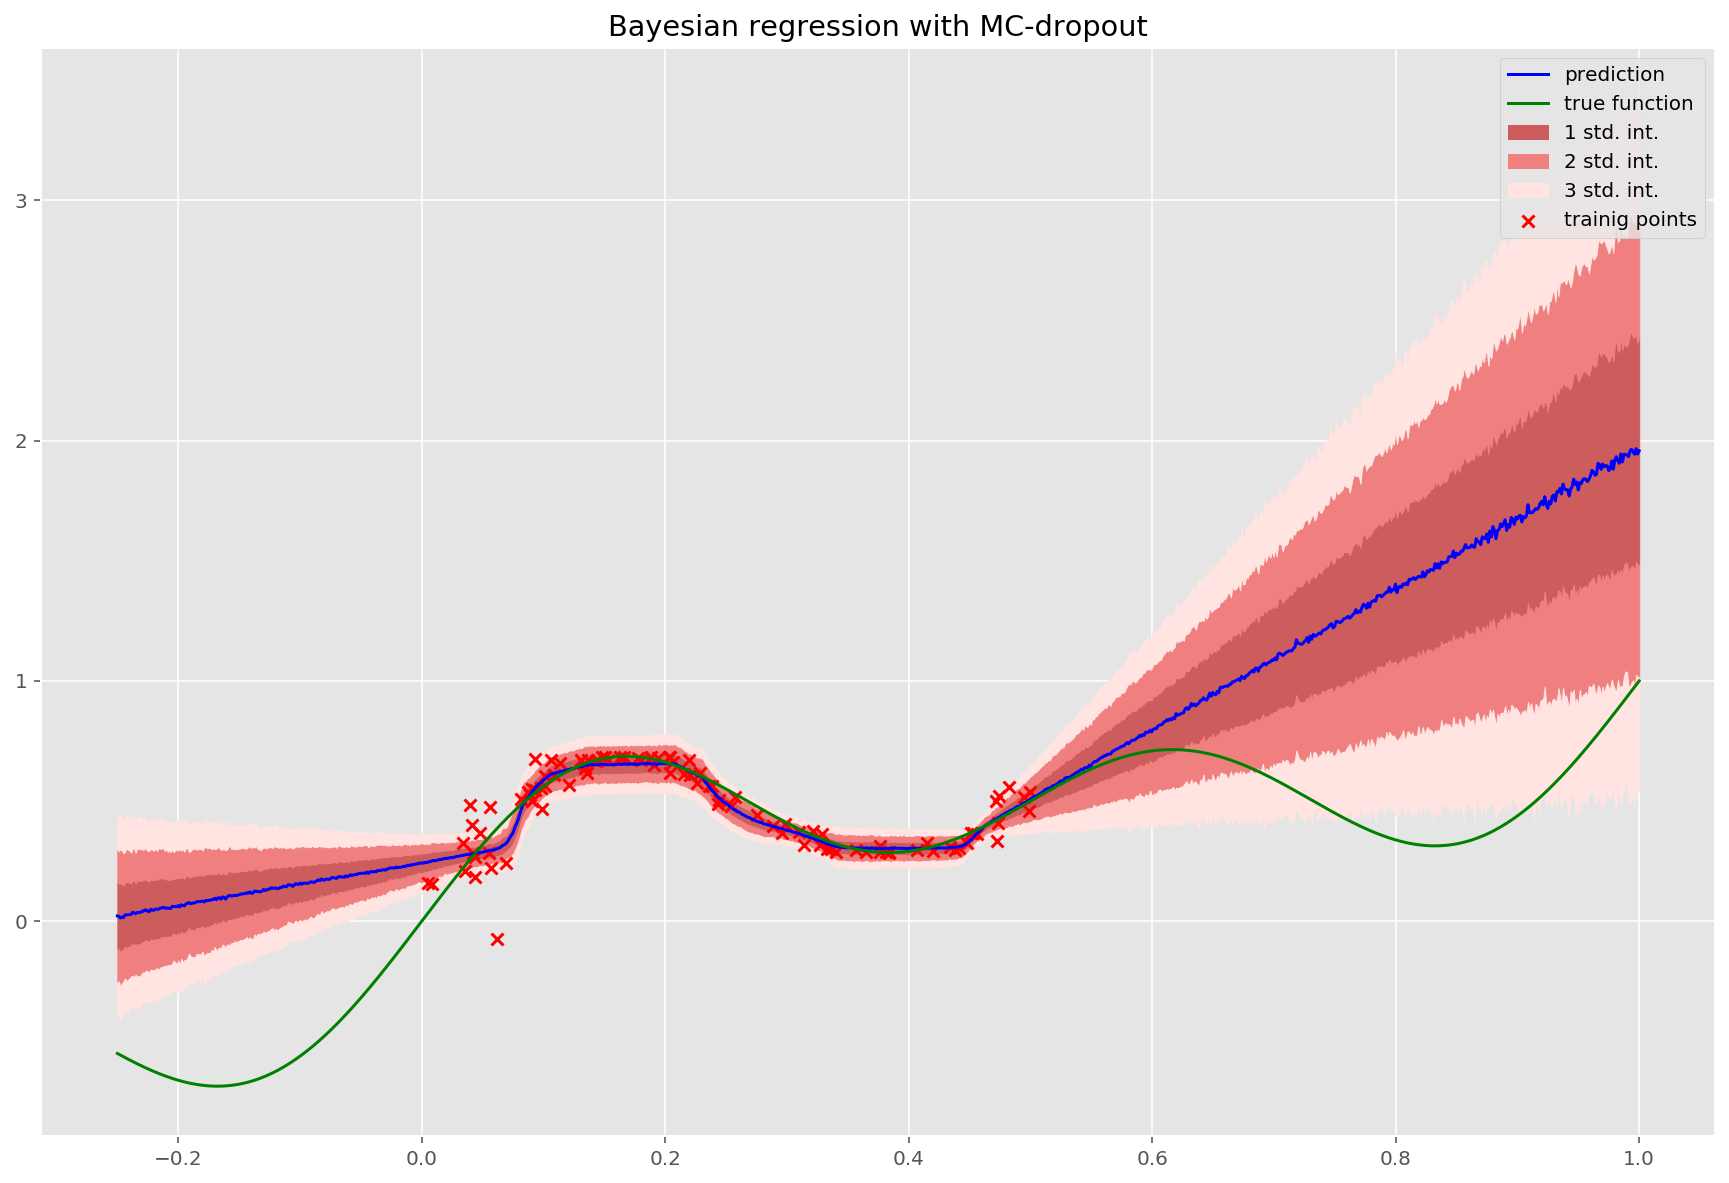

In [26]:
plt.figure(figsize=(15, 10))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.title("Bayesian regression with MC-dropout")
plt.show()

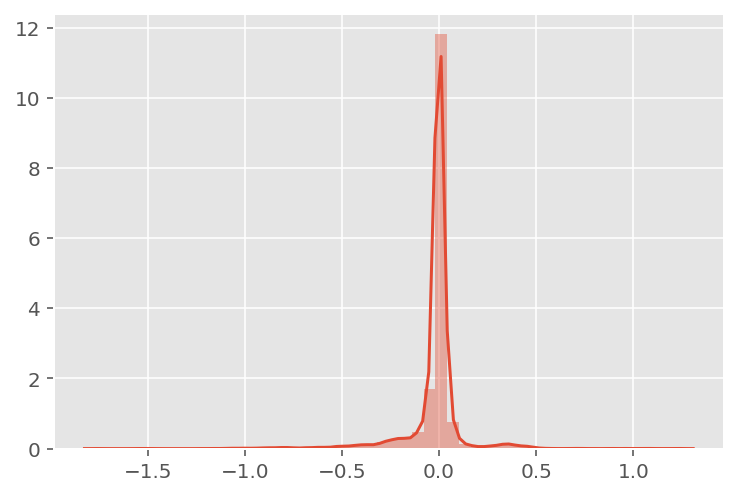

In [27]:
sns.distplot(net.weights_dist())
plt.show()

In [28]:
def log_likelihood(y, output, sigma=0.06):
    return torch.sum(-0.5 * np.log(2 * np.pi * sigma ** 2) - 0.5 * (y.squeeze() - output.squeeze()) ** 2 / sigma ** 2)

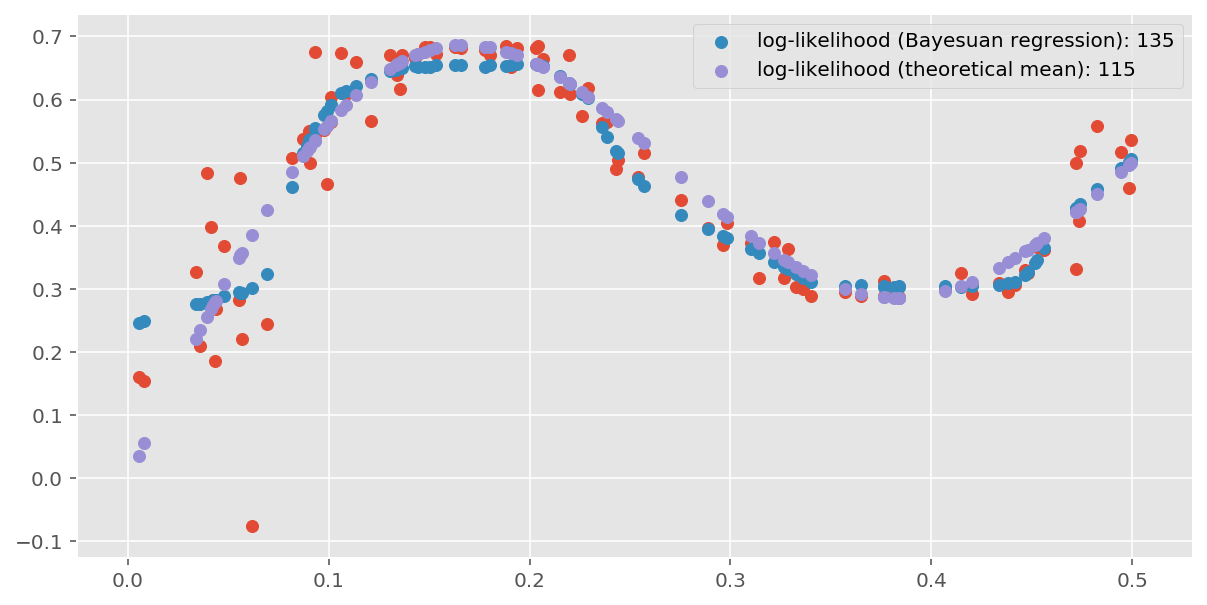

In [29]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(1000):
    y += net(reg_model.X_train) / 1000

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'log-likelihood (Bayesuan regression): {log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'log-likelihood (theoretical mean): {log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()

## 3. Bayesian regression with Bayesian by Backpropagation

In [45]:
import models.bayesbackprop_regression as bbb

##### Definition of the model

In [84]:
prior_parameters = {'sigma1': 1, 'sigma2': np.exp(-6), 'pi': 0.5}
net = bbb.BayesBackpropNet(hidden_size=64, dim_input=1, dim_output=1, prior_parameters=prior_parameters, sigma=0.06)
reg_model = bbb.BayesBackpropReg(X_train_tensor, y_train_tensor, X_test_tensor, net, batch_size=10)

In [104]:
list(net.fc2.parameters())

[Parameter containing:
 tensor([[-5.4234e-01, -1.4906e-01, -7.7847e-01,  ..., -1.2290e-01,
          -2.8314e-01, -6.5237e-01],
         [-1.6170e-01, -5.4881e-01,  4.4914e-02,  ..., -2.2440e-01,
          -2.9810e-02, -9.0485e-01],
         [-3.1394e-01, -6.2678e-02, -1.2886e-01,  ..., -4.4347e-02,
          -3.8678e-38, -4.2818e-01],
         ...,
         [-1.6288e-01, -6.7917e-01, -2.3197e-01,  ..., -5.4824e-02,
          -2.7350e-01, -8.8313e-01],
         [-2.2223e-01, -3.6051e-01, -1.4476e-01,  ...,  5.6126e-02,
          -3.8679e-02, -1.1573e+00],
         [-4.7243e-02, -6.8567e-03, -6.3482e-01,  ..., -6.9214e-02,
          -5.5725e-02, -5.3277e-01]], requires_grad=True),
 Parameter containing:
 tensor([[-3.2772e-01, -1.1411e-01, -3.7683e-01,  ..., -8.1012e-02,
          -2.7375e-01, -5.2425e-01],
         [ 1.8997e-01, -2.2529e-01,  1.8044e-02,  ..., -7.9731e-04,
          -2.5770e-18, -2.1791e-01],
         [ 3.0103e-01, -1.4891e-01, -1.1539e-01,  ..., -3.6138e-02,
          

##### Training step

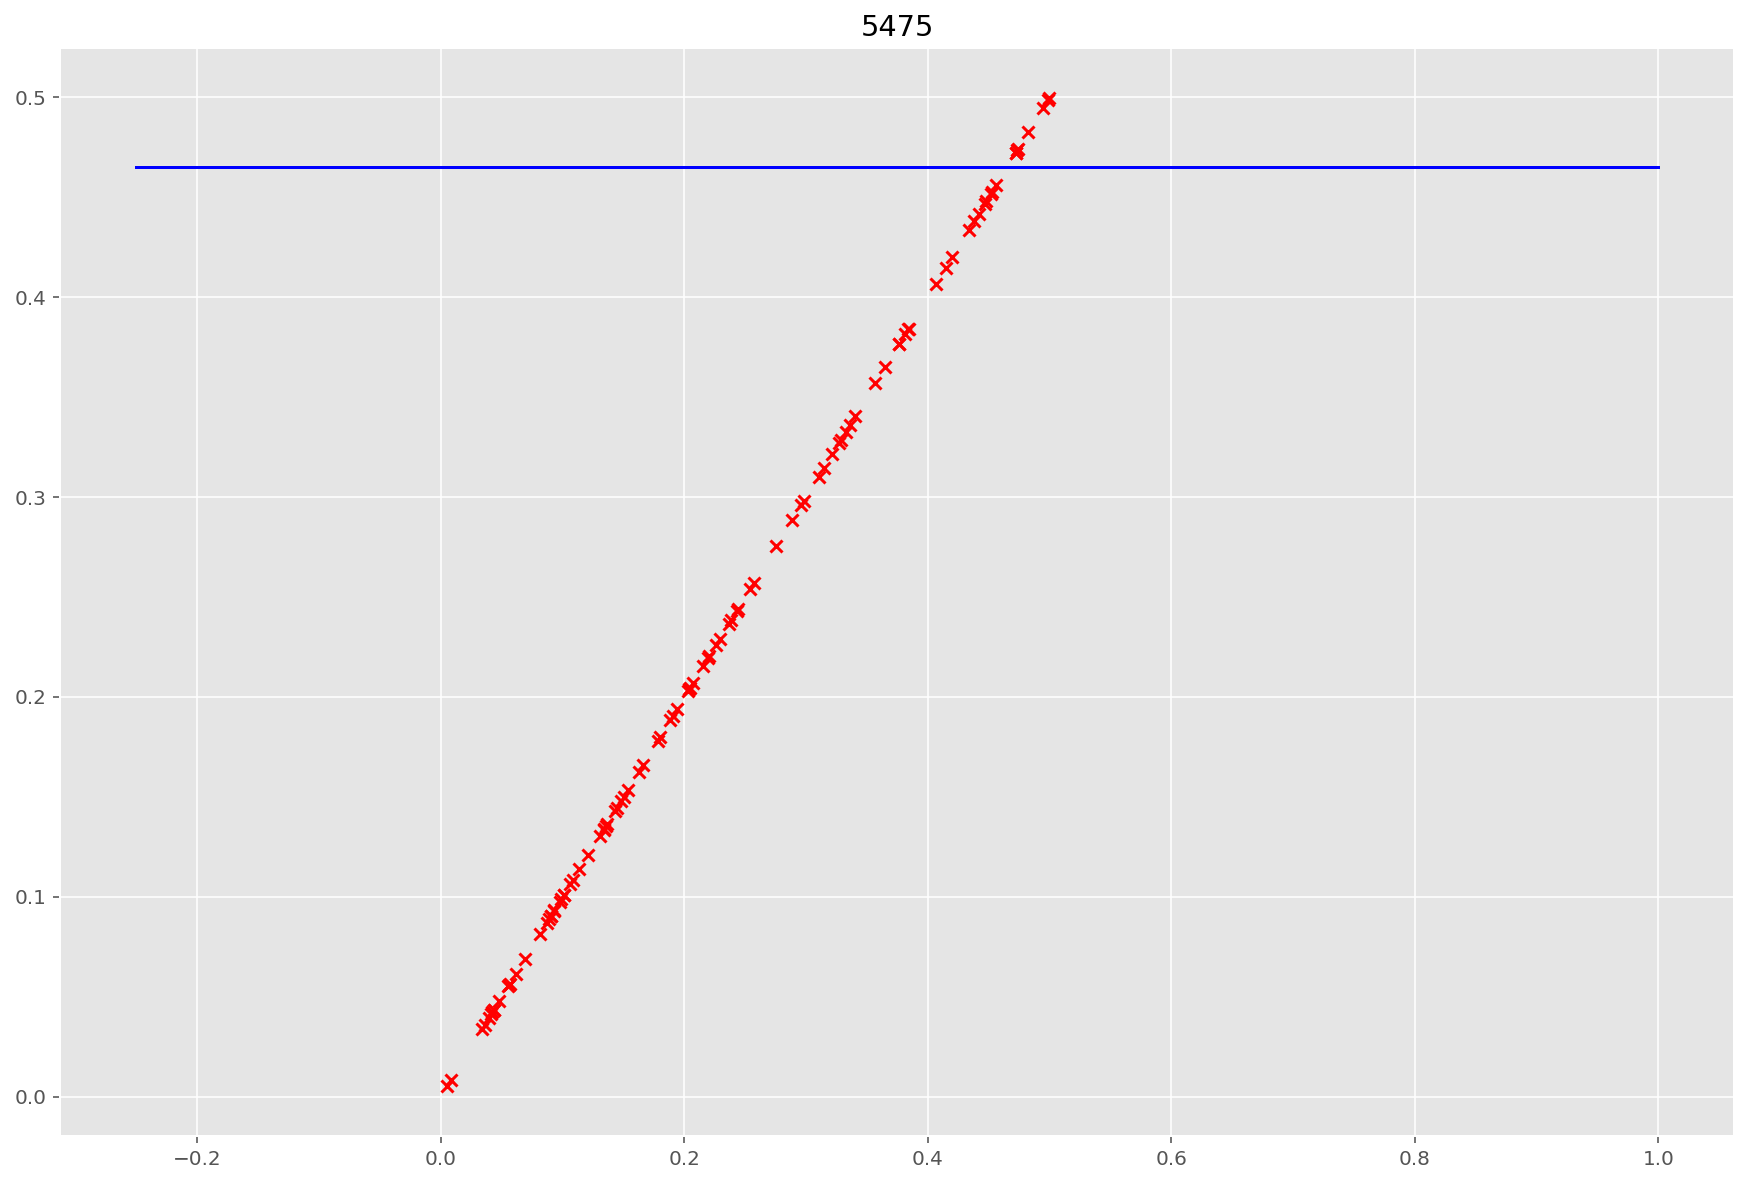

5500: 193.584335
5550: 193.673309
5600: 192.653564
5650: 192.713913


KeyboardInterrupt: 

In [93]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
for i in range(20):
    reg_model.train(250, optimizer, 2, 'geometric')
    clear_output()
    y_pred_mean, y_pred_std = reg_model.predict(samples=10)
    plt.figure(figsize=(15, 10))
    reg_model.plot_results()
    plt.title(f"{reg_model.epoch}")
    plt.show()

##### Test step

In [98]:
y_pred_mean, y_pred_std = reg_model.predict(samples=1000)

##### Plot results

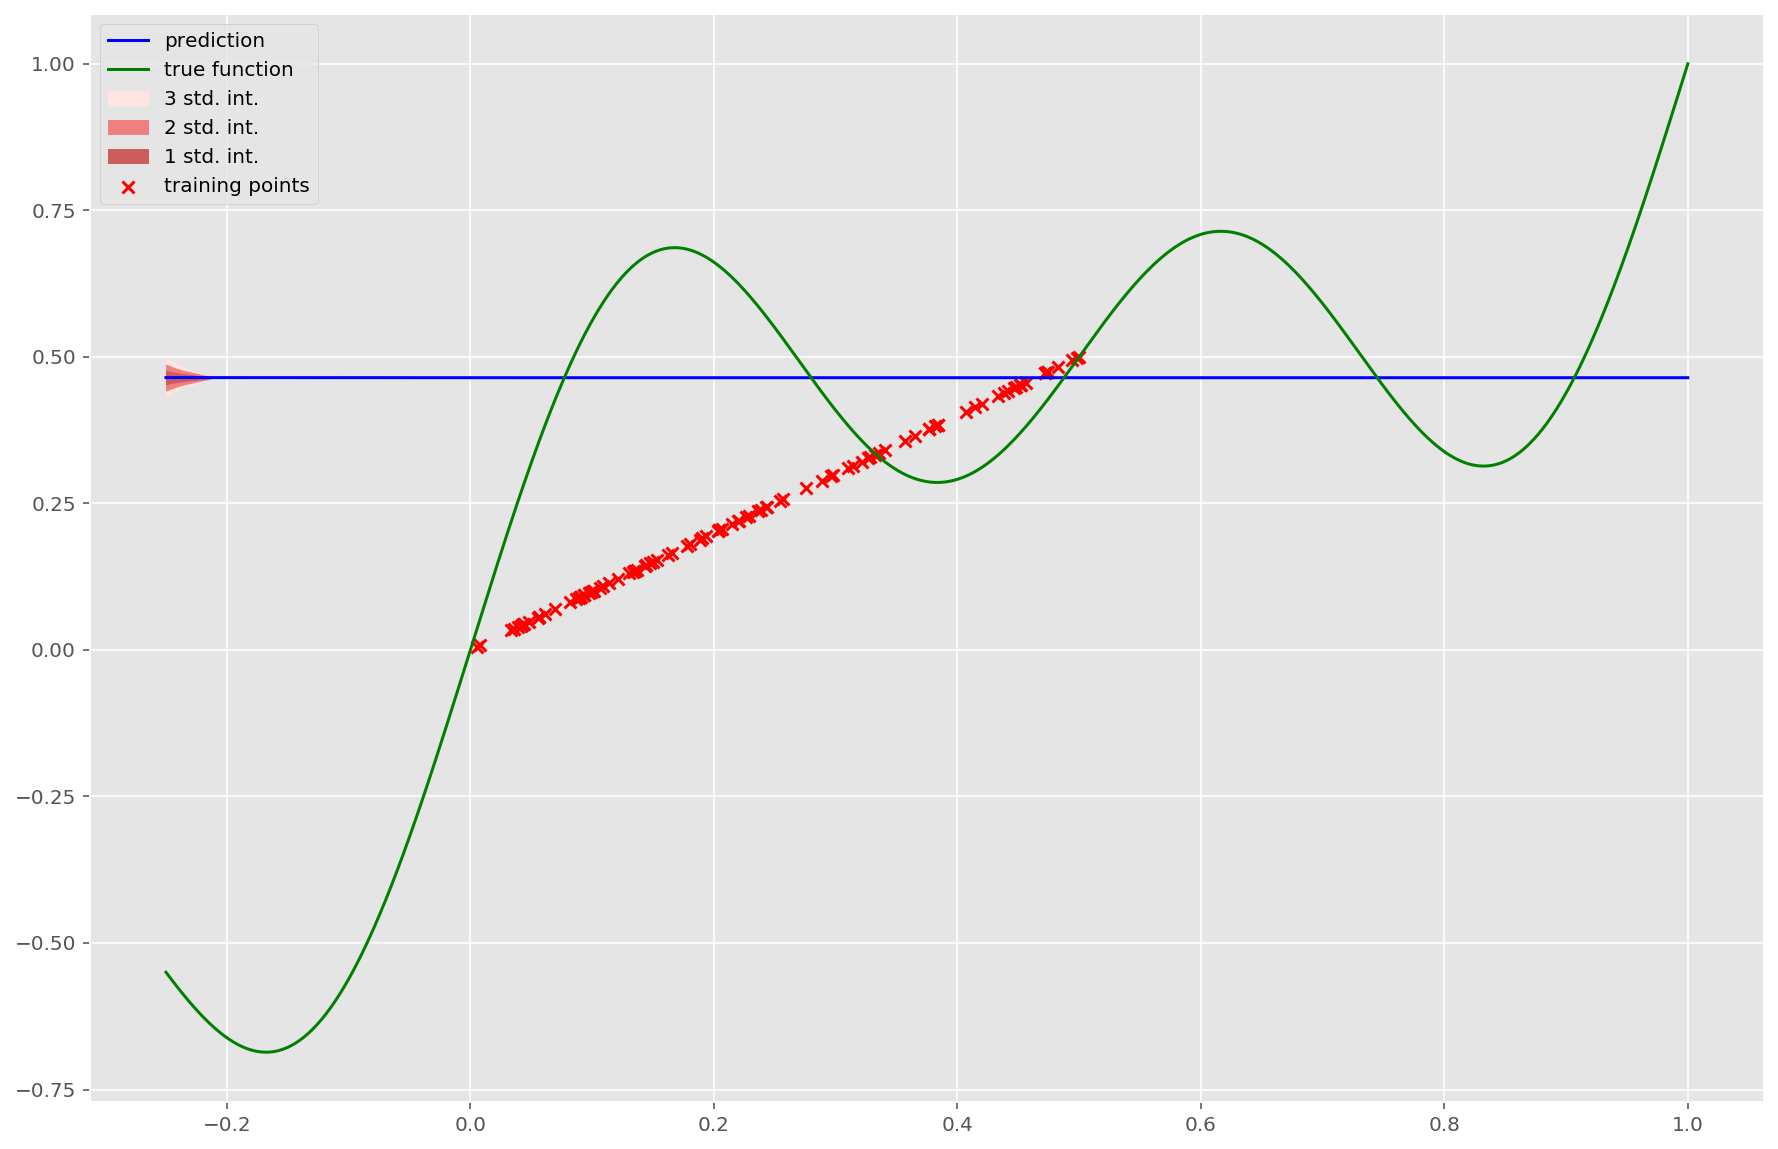

In [99]:
plt.figure(figsize=(15, 10))
reg_model.plot_results()
plt.plot(dataset['X_test'], F, color='green', label='true function')
plt.legend()
plt.show()

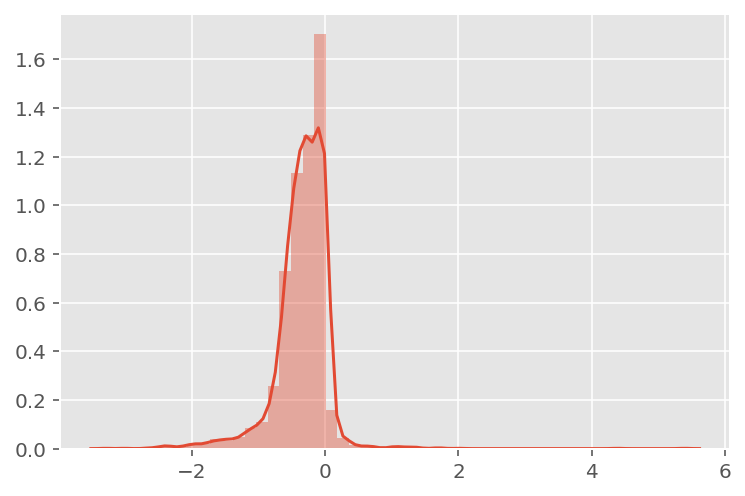

In [81]:
sns.distplot(net.weights_dist())
plt.show()

In [82]:
net(torch.tensor([[0.],[1.]]))

tensor([[0.4628],
        [0.4628]], grad_fn=<AddmmBackward>)

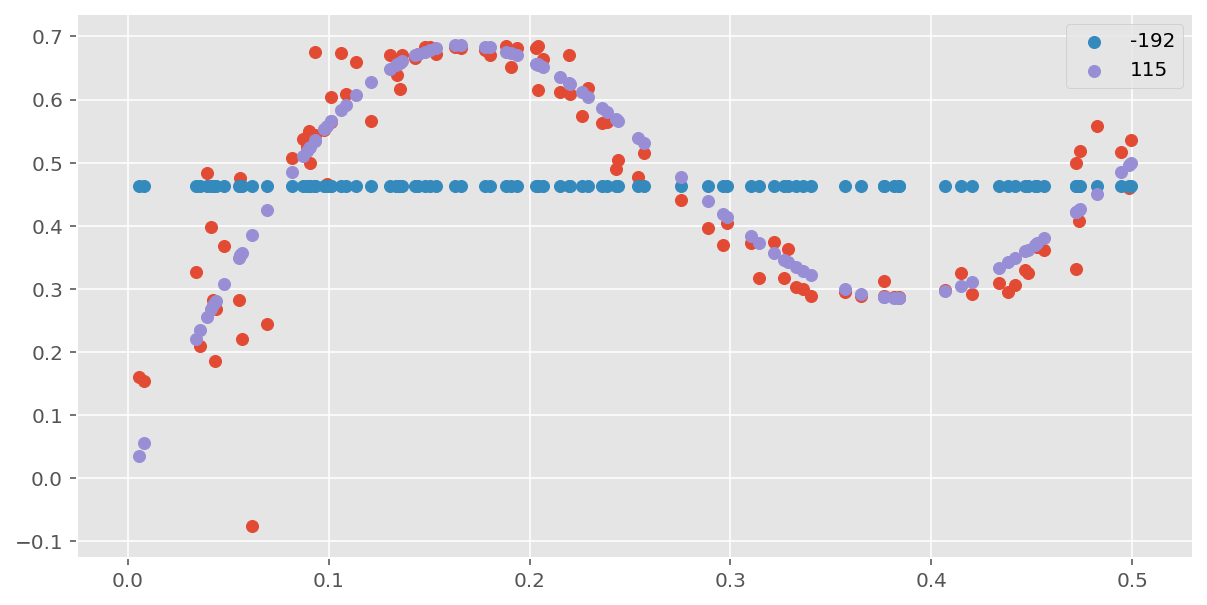

In [83]:
y = torch.zeros_like(net(reg_model.X_train))
for i in range(100):
    y += net(reg_model.X_train) / 100

plt.figure(figsize=(10, 5))
plt.scatter(reg_model.X_train, reg_model.y_train)
plt.scatter(reg_model.X_train, y.detach(), label=f'{log_likelihood(reg_model.y_train, y):.0f}')
plt.scatter(reg_model.X_train, function(reg_model.X_train, 0), label=f'{log_likelihood(reg_model.y_train, function(reg_model.X_train, 0)):.0f}')
plt.legend()
plt.show()